In [13]:
import numpy as np

from qiskit.quantum_info.operators.predicates import (is_hermitian_matrix,
                                                      is_unitary_matrix)
from scipy.linalg import expm
import tensornetwork as tn

In [14]:
def unitary_from_hermitian(hermitian):
    """Generates a unitary matrix from a hermitian matrix.
        The formula is U = e^(i*H).

    Args:
        hermitian: A hermitian matrix.

    Returns:
        unitary: The resulting unitarian matrix.

    Raises:
        AssertionError: If the resulting matrix is not unitarian.
    """
    unitary = np.array(expm(1j * hermitian))
    assert is_unitary_matrix(unitary)
    return unitary


def hermitian_from_weights(weights, dimension):
    """Generates a  complex hermitian matrix from a set of weights.
        The hermitian is constructed by an upper triangle matrix which then is
        added to its transpose. The first dimension weights are used for the real
        diagonal values, the next values are used for the real parts of the upper
        triangle the rest for the imaginarie parts.

    Args:
        weights: List of weights.
        dimension: size of the matrix.

    Returns:
        hermitian: The resulting hermitian matrix.

    Raises:
        AssertionError: If the resulting matrix is not hermitian.
    """
    diagonals = weights[:dimension]
    dim = ((dimension**2 - dimension) // 2) + dimension
    reals = weights[dimension:dim]
    imaginaries = weights[dim:]
    assert reals.shape == imaginaries.shape
    diag = np.matrix(np.diag(diagonals))
    hermitian = np.matrix(np.zeros((dimension, dimension), dtype=complex))

    hermitian[np.triu_indices(dimension, 1)] = np.array(
        [complex(a, b) for a, b in zip(reals, imaginaries)])
    hermitian = hermitian + hermitian.H + diag  # tril and triu don't use the same ordering!
    assert is_hermitian_matrix(hermitian)
    return hermitian


def unitaries_from_weights(weights, dimension=4):
    """Wrapper function to generate unitary matricies from weight list.

    Args:
        weights: The weights to transform.

    Returns:
        unitaries: The resulting list of unitary matrices.
    """
    unitaries = []
    for weight in weights:
        unitaries.append(
            unitary_from_hermitian(hermitian_from_weights(weight, dimension)))
    return unitaries

In [15]:
# Root parameters

input_length = 16
v = 1

# Generating random input data

data = np.random.normal(size=(input_length))

# Derived parameters

gates_per_step = []
gates_per_step.append(input_length // (2**v))

steps = int(np.log2(gates_per_step[0])) + 1 # +1 as we added the first step already

for i in range(1, steps):
    gates_per_step.append(gates_per_step[i-1]//2)

# Cummulative gates in a given step
c_gates = [0]  

sum_ = 0 
for i in range(len(gates_per_step)):
    sum_ += 2*gates_per_step[i]
    c_gates.append(sum_)

In [16]:
# Constructing the unitary matrices that make the quantum circuit
weights = np.random.normal(size=(int(sum(gates_per_step)), 2**(4*v)))
unitaries = unitaries_from_weights(weights, int(np.sqrt(input_length)))

In [17]:
# Transform the unitary matrixes into tensors
tensor_network = []

redistribute_indexes = [2 for i in range(int(np.log2(unitaries[0].size)))]

for i, unitary in enumerate(unitaries):
    tensor_network.append(tn.Node(unitary.reshape(redistribute_indexes), name=f'unitary_{i}'))
    tensor_network.append(tn.Node(unitary.conjugate().T.reshape(redistribute_indexes), name=f'unitary_{i+1}'))

In [18]:
# Preparing the tensors holding the data and connecting their edges to the unitary tensors
feature_map = np.zeros((data.shape[0], 2))
tensor_data = []

for i in range(gates_per_step[0]):
    for k in range(2*v):
        l = i*2*v+k # Index in the input data array of length dim**2x1 
        idx= 2*i*2*v+k # Index in the array of dual and non-dual vectors of length 2*dim**2x1
        feature_map[l][0] = np.cos(np.pi / 2 * data[l])
        feature_map[l][1] = np.sin(np.pi / 2 * data[l])
        tensor_data.append(tn.Node(feature_map[l], name=f'data_{idx}'))
        # print(f'Normal unitary_id:{2*i} tensor_data:{idx}')
        tensor_network[2*i][k]^tensor_data[idx][0]
        
    for k in range(2*v):
        l = i*2*v+k
        idx= 2*i*2*v+k
        # print(f'H unitary_id:{2*i+1} tensor_data_h:{idx+2*v}')
        tensor_data.append(tn.Node(feature_map[l].T, name=f'data_h_{idx}'))
        tensor_network[2*i+1][k]^tensor_data[idx+2*v][0]

In [19]:
# Doing the necessary edge connections between the tensors
idx = 0
for i in range(steps-1): # Last execution is peeled off, as there's no 'next tensor' to link
    for j in range(gates_per_step[i]):
        # Within a given gate
        gate_idx = 2*j+c_gates[i]
        for k in range(v):
            tensor_network[gate_idx][2*v+k] ^ tensor_network[gate_idx+1][2*v+k]
            # print(f'Unitary_id:{gate_idx} Unitary_H_id:{gate_idx+1} thru edge:{2*v+k}->{2*v+k}\n')
        for k in range(v):
            # print(f'Unitary_id:{gate_idx} Unitary_next_id:{((gate_idx-c_gates[i])//4)*2+c_gates[i+1]} thru edge:{k+3*v}->{((gate_idx//2)%2)*v+k}\n')
            # print(f'Unitary_H_id:{gate_idx+1} Unitary_H_next_id:{((gate_idx-c_gates[i])//4)*2+c_gates[i+1]+1} thru edge:{k+3*v}->{((gate_idx//2)%2)*v+k}\n')
            tensor_network[gate_idx][k+3*v] ^ tensor_network[((gate_idx-c_gates[i])//4)*2+c_gates[i+1]][((gate_idx//2)%2)*v+k] 
            tensor_network[gate_idx+1][k+3*v] ^ tensor_network[((gate_idx-c_gates[i])//4)*2+c_gates[i+1]+1][((gate_idx//2)%2)*v+k]

In [20]:
# Contracting the last tensor in the network
gate_idx = c_gates[-2] # Remember we appended an offset 0, thus -2 instead of -1
for k in range((2*v)-1):
    tensor_network[gate_idx][2*v+k] ^ tensor_network[gate_idx+1][2*v+k]
    # print(f'Unitary_id:{gate_idx} Unitary_H_id:{gate_idx+1} thru edge:{2*v+k}->{2*v+k}\n')

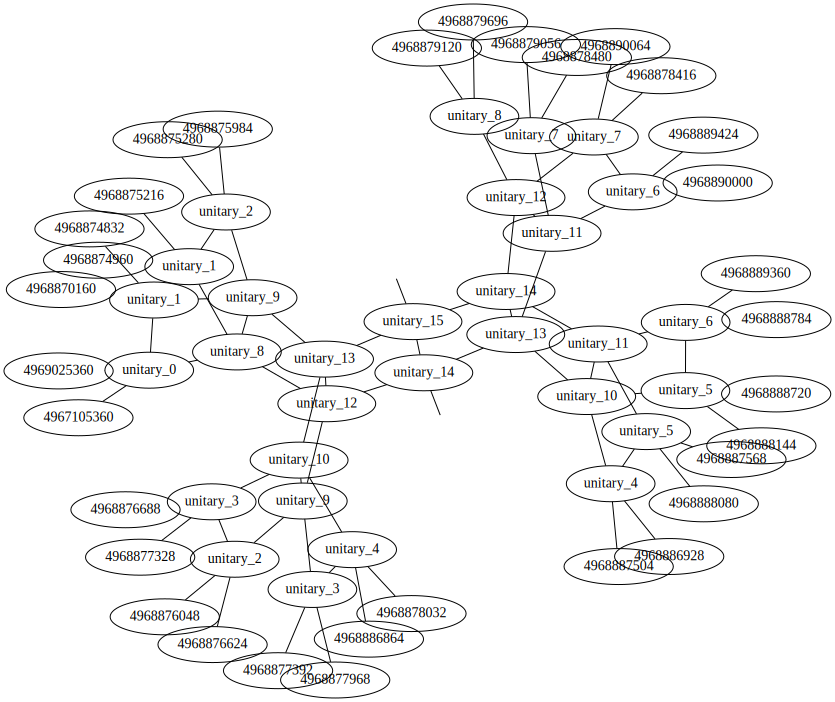

In [27]:
tn.to_graphviz(tensor_network)

In [ ]:
result = tn.contractors.auto(tensor_network, ignore_edge_order=True)